In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


import matplotlib.image as image

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
!ls -la /data

total 19356
drwxr-xr-x 14 root root    4096 Feb 28 03:41 .
drwxr-xr-x  1 root root    4096 May 29 15:04 ..
-rw-r--r--  1 root root 8963138 Sep 25  2019 ARXIV_V5_CHESTXRAY.pdf
-rw-r--r--  1 root root   92416 Sep 25  2019 BBox_List_2017.csv
-rw-r--r--  1 root root 7861152 Sep 25  2019 Data_Entry_2017.csv
-rw-r--r--  1 root root   72223 Sep 25  2019 FAQ_CHESTXRAY.pdf
drwxr-xr-x  3 root root    4096 Feb 28 03:20 images_001
drwxr-xr-x  3 root root    4096 Feb 28 03:20 images_002
drwxr-xr-x  3 root root    4096 Feb 28 03:21 images_003
drwxr-xr-x  3 root root    4096 Feb 28 03:22 images_004
drwxr-xr-x  3 root root    4096 Feb 28 03:23 images_005
drwxr-xr-x  3 root root    4096 Feb 28 03:24 images_006
drwxr-xr-x  3 root root    4096 Feb 28 03:24 images_007
drwxr-xr-x  3 root root    4096 Feb 28 03:25 images_008
drwxr-xr-x  3 root root    4096 Feb 28 03:26 images_009
drwxr-xr-x  3 root root    4096 Feb 28 03:27 images_010
drwxr-xr-x  3 root root    4096 Feb 28 03:28 images_011
drwxr-xr-x  3 roo

In [3]:
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
38441  00010050_009.png     No Finding            9       10050           78   
27463  00007151_001.png     No Finding            1        7151           49   
82939  00020398_001.png         Nodule            1       20398           21   

      Patient Gender View Position  OriginalImage[Width  Height]  \
38441              M            AP                 2500     2048   
27463              F            PA                 2048     2500   
82939              F            PA                 2598     2991   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  
38441                        0.168  0.168          NaN  
27463                        0.168  0.168          NaN  
82939                        0.143  0.143          NaN

In [4]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [5]:
## Loading the 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
2501  00012596_000.png     No Finding            0       12596        049Y   
1764  00009328_000.png     No Finding            0        9328        030Y   
2492  00012573_000.png     No Finding            0       12573        017Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
2501              M            PA                2992                 2991   
1764              F            PA                2500                 2048   
2492              F            PA                2048                 2500   

      OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  
2501                        0.143                        0.143  
1764                        0.168                        0.168  
2492                        0.168                        0.168

In [6]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


## Analysis of field distributions

#### Age

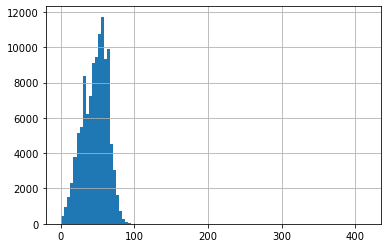

In [7]:
h = all_xray_df['Patient Age'].hist(bins=100)

In [8]:
over100 = all_xray_df[all_xray_df['Patient Age'] > 100]
print(len(over100))
over100

16


Image Index           Finding Labels  Follow-up #  Patient ID  \
20852   00005567_000.png       Effusion|Pneumonia            0        5567   
46965   00011973_002.png                    Edema            2       11973   
48284   00012238_010.png               No Finding           10       12238   
55742   00013950_000.png               No Finding            0       13950   
58650   00014520_026.png        Infiltration|Mass           26       14520   
62929   00015558_000.png               No Finding            0       15558   
74884   00018366_044.png             Pneumothorax           44       18366   
78795   00019346_000.png             Infiltration            0       19346   
84810   00020900_002.png               No Finding            2       20900   
85404   00021047_002.png  Mass|Pleural_Thickening            2       21047   
86264   00021275_003.png               No Finding            3       21275   
91369   00022811_000.png               No Finding            0       22811   
95794   00025206_000.png        Infiltration|Mass            0       25206   
98495   00026028_001.png              Atelectasis            1       26028   
101194  00026871_000.png               No Finding            0       26871   
104590  00027989_000.png               No Finding            0       27989   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
20852           412              M            AP                 3056   
46965           414              M            AP                 3056   
48284           148              M            PA                 2992   
55742           148              M            PA                 2964   
58650           150              M            PA                 2992   
62929           149              M            PA                 2992   
74884           152              F            PA                 2302   
78795           151              F            PA                 2678   
84810           411              M            AP                 3056   
85404           412              M            AP                 3056   
86264           413              F            AP                 3056   
91369           412              M            PA                 3056   
95794           153              M            PA                 2992   
98495           154              M            PA                 2992   
101194          155              F            PA                 2992   
104590          155              M            PA                 2992   

        Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11  
20852      2544                        0.139  0.139          NaN  
46965      2544                        0.139  0.139          NaN  
48284      2991                        0.143  0.143          NaN  
55742      2939                        0.143  0.143          NaN  
58650      2991                        0.143  0.143          NaN  
62929      2991                        0.143  0.143          NaN  
74884      2991                        0.143  0.143          NaN  
78795      2774                        0.143  0.143          NaN  
84810      2544                        0.139  0.139          NaN  
85404      2544                        0.139  0.139          NaN  
86264      2544                        0.139  0.139          NaN  
91369      2544                        0.139  0.139          NaN  
95794      2991                        0.143  0.143          NaN  
98495      2991                        0.143  0.143          NaN  
101194     2991                        0.143  0.143          NaN  
104590     2991                        0.143  0.143          NaN

We have 16 records with Patient Age over 100, actually all of them are over 140. Obviously, this is some mistake, so we can simply set those to 100, so at least it falls within feasible range. 

In [9]:
all_xray_df['Patient Age'] = all_xray_df.apply(lambda x: 101 if x['Patient Age'] > 100 else x['Patient Age'], axis=1)

In [10]:
over100 = all_xray_df[all_xray_df['Patient Age'] > 100]
print(len(over100))
over100

16


Image Index           Finding Labels  Follow-up #  Patient ID  \
20852   00005567_000.png       Effusion|Pneumonia            0        5567   
46965   00011973_002.png                    Edema            2       11973   
48284   00012238_010.png               No Finding           10       12238   
55742   00013950_000.png               No Finding            0       13950   
58650   00014520_026.png        Infiltration|Mass           26       14520   
62929   00015558_000.png               No Finding            0       15558   
74884   00018366_044.png             Pneumothorax           44       18366   
78795   00019346_000.png             Infiltration            0       19346   
84810   00020900_002.png               No Finding            2       20900   
85404   00021047_002.png  Mass|Pleural_Thickening            2       21047   
86264   00021275_003.png               No Finding            3       21275   
91369   00022811_000.png               No Finding            0       22811   
95794   00025206_000.png        Infiltration|Mass            0       25206   
98495   00026028_001.png              Atelectasis            1       26028   
101194  00026871_000.png               No Finding            0       26871   
104590  00027989_000.png               No Finding            0       27989   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
20852           101              M            AP                 3056   
46965           101              M            AP                 3056   
48284           101              M            PA                 2992   
55742           101              M            PA                 2964   
58650           101              M            PA                 2992   
62929           101              M            PA                 2992   
74884           101              F            PA                 2302   
78795           101              F            PA                 2678   
84810           101              M            AP                 3056   
85404           101              M            AP                 3056   
86264           101              F            AP                 3056   
91369           101              M            PA                 3056   
95794           101              M            PA                 2992   
98495           101              M            PA                 2992   
101194          101              F            PA                 2992   
104590          101              M            PA                 2992   

        Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11  
20852      2544                        0.139  0.139          NaN  
46965      2544                        0.139  0.139          NaN  
48284      2991                        0.143  0.143          NaN  
55742      2939                        0.143  0.143          NaN  
58650      2991                        0.143  0.143          NaN  
62929      2991                        0.143  0.143          NaN  
74884      2991                        0.143  0.143          NaN  
78795      2774                        0.143  0.143          NaN  
84810      2544                        0.139  0.139          NaN  
85404      2544                        0.139  0.139          NaN  
86264      2544                        0.139  0.139          NaN  
91369      2544                        0.139  0.139          NaN  
95794      2991                        0.143  0.143          NaN  
98495      2991                        0.143  0.143          NaN  
101194     2991                        0.143  0.143          NaN  
104590     2991                        0.143  0.143          NaN

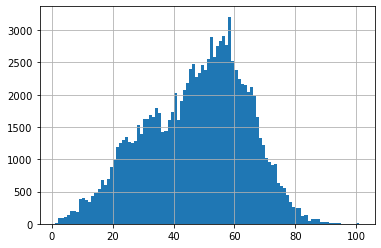

In [11]:
h = all_xray_df['Patient Age'].hist(bins=100)

The Age distubution is roughly normal, somewhat skewed right, with peak around 58 years. 


In [12]:
all_xray_df[all_xray_df['Patient Age'] <= 100][['Patient Age']].describe()

Patient Age
count  112104.000000
mean       46.872574
std        16.598152
min         1.000000
25%        35.000000
50%        49.000000
75%        59.000000
max        95.000000

##### Patient age range: from 1 to 95 years old

#### Gender

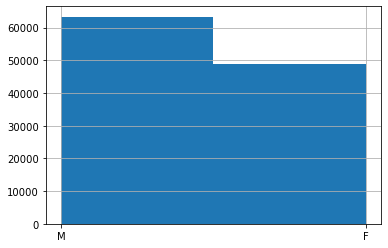

In [13]:
all_xray_df['Patient Gender'].hist(bins=2)

In [14]:
gender_m = all_xray_df[all_xray_df['Patient Gender'] == 'M']
gender_f = all_xray_df[all_xray_df['Patient Gender'] == 'F']

<BarContainer object of 2 artists>

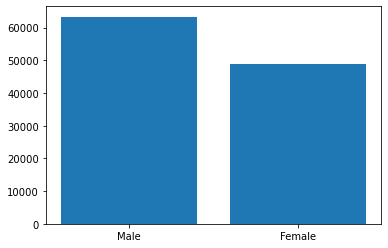

In [15]:
plt.bar(['Male','Female'], [len(gender_m), len(gender_f)])

In [16]:
print(f'Patien Gender distribution\nMale: {len(gender_m)} ({100.0*len(gender_m)/len(all_xray_df):.2f}%), Female: {len(gender_f)} ({100.0*len(gender_f)/len(all_xray_df):.2f}%)')

Patien Gender distribution
Male: 63340 (56.49%), Female: 48780 (43.51%)


#### View position

In [17]:
all_xray_df['View Position'].unique()

array(['PA', 'AP'], dtype=object)

<BarContainer object of 2 artists>

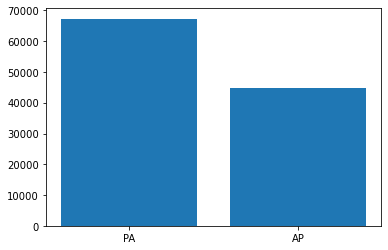

In [18]:
pos_pa = all_xray_df[all_xray_df['View Position'] == 'PA']
pos_ap = all_xray_df[all_xray_df['View Position'] == 'AP']
plt.bar(['PA','AP'], [len(pos_pa), len(pos_ap)])

In [19]:
print(f'View position value distribution\nPA: {len(pos_pa)} ({100.0*len(pos_pa)/len(all_xray_df):.2f}%), AP: {len(pos_ap)} ({100.0*len(pos_ap)/len(all_xray_df):.2f}%)')

View position value distribution
PA: 67310 (60.03%), AP: 44810 (39.97%)


#### Follow-up number

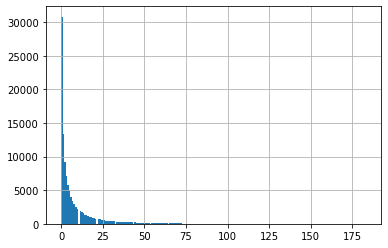

In [20]:
all_xray_df['Follow-up #'].hist(bins=200)

In [21]:
all_xray_df['Follow-up #'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [22]:
follow_up_0 = all_xray_df[all_xray_df['Follow-up #']==0]
print(f'Follow-up number 0 (first visit): {len(follow_up_0)} ({100.0*len(follow_up_0)/len(all_xray_df) :.2f}%)')

follow_up_1 = all_xray_df[all_xray_df['Follow-up #']==1]
print(f'Follow-up number 1 (second visit): {len(follow_up_1)} ({100.0*len(follow_up_1)/len(all_xray_df) :.2f}%)')

follow_up_2 = all_xray_df[all_xray_df['Follow-up #']==2]
print(f'Follow-up number 2 (second visit): {len(follow_up_2)} ({100.0*len(follow_up_2)/len(all_xray_df) :.2f}%)')

follow_up_3 = all_xray_df[all_xray_df['Follow-up #']==3]
print(f'Follow-up number 3 (second visit): {len(follow_up_3)} ({100.0*len(follow_up_3)/len(all_xray_df) :.2f}%)')

follow_up_4 = all_xray_df[all_xray_df['Follow-up #']==4]
print(f'Follow-up number 4 (second visit): {len(follow_up_4)} ({100.0*len(follow_up_4)/len(all_xray_df) :.2f}%)')

Follow-up number 0 (first visit): 30805 (27.48%)
Follow-up number 1 (second visit): 13302 (11.86%)
Follow-up number 2 (second visit): 9189 (8.20%)
Follow-up number 3 (second visit): 7089 (6.32%)
Follow-up number 4 (second visit): 5759 (5.14%)


The follow-up number seems to follow the exponential distribution, from 0 to max number of 183.

#### Finding Labels

In [23]:
all_xray_df['Finding Labels'].unique()

array(['Cardiomegaly', 'Cardiomegaly|Emphysema', 'Cardiomegaly|Effusion',
       'No Finding', 'Hernia', 'Hernia|Infiltration', 'Mass|Nodule',
       'Infiltration', 'Effusion|Infiltration', 'Nodule', 'Emphysema',
       'Effusion', 'Atelectasis', 'Effusion|Mass',
       'Emphysema|Pneumothorax', 'Pleural_Thickening',
       'Effusion|Emphysema|Infiltration|Pneumothorax',
       'Emphysema|Infiltration|Pleural_Thickening|Pneumothorax',
       'Effusion|Pneumonia|Pneumothorax', 'Pneumothorax',
       'Effusion|Infiltration|Pneumothorax', 'Infiltration|Mass',
       'Infiltration|Mass|Pneumothorax', 'Mass',
       'Cardiomegaly|Infiltration|Mass|Nodule',
       'Cardiomegaly|Effusion|Emphysema|Mass',
       'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax',
       'Emphysema|Mass', 'Emphysema|Mass|Pneumothorax',
       'Atelectasis|Pneumothorax', 'Cardiomegaly|Emphysema|Pneumothorax',
       'Mass|Pleural_Thickening', 'Cardiomegaly|Mass|Pleural_Thickening',
       'Effusion|Infiltra

In [24]:
all_xray_df['Finding Labels'].nunique()

836

In [25]:
findings = set()
for f in all_xray_df['Finding Labels'].unique():
    findings.update(f.split('|'))
print(f'Total number of single diagnoses: {len(findings)}')
findings

Total number of single diagnoses: 15


{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

In [26]:
no_finding = all_xray_df[all_xray_df['Finding Labels'] == 'No Finding']
print(f'No finding: {len(no_finding)} ({100.0*len(no_finding)/len(all_xray_df) :.2f}%)')

No finding: 60361 (53.84%)


#### Patient ID

In [27]:
unique_patients_num = all_xray_df['Patient ID'].nunique()
print(f'Total unique patients: {unique_patients_num}, average number records per patient: {len(all_xray_df)/unique_patients_num :.2f}')

Total unique patients: 30805, average number records per patient: 3.64


In [28]:
records_per_patient = []
for pid in all_xray_df['Patient ID'].unique():
    records_per_patient.append(len(all_xray_df[all_xray_df['Patient ID'] == pid]))


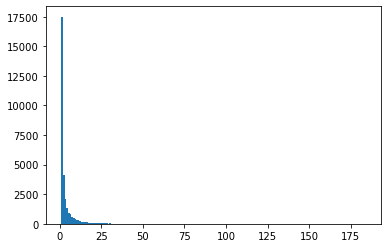

In [29]:
plt.hist(records_per_patient, bins=max(records_per_patient))
plt.show()

In [30]:
def num_patients_with_records(num):
    return (np.array(records_per_patient) == num*np.ones(len(records_per_patient))).sum()

In [31]:
for i in range(1,11):
    print(f'Number of patients with {i} records in the dataset: {num_patients_with_records(i)} ({100.0*num_patients_with_records(i)/unique_patients_num :.2f})')


Number of patients with 1 records in the dataset: 17503 (56.82)
Number of patients with 2 records in the dataset: 4113 (13.35)
Number of patients with 3 records in the dataset: 2100 (6.82)
Number of patients with 4 records in the dataset: 1330 (4.32)
Number of patients with 5 records in the dataset: 938 (3.04)
Number of patients with 6 records in the dataset: 787 (2.55)
Number of patients with 7 records in the dataset: 608 (1.97)
Number of patients with 8 records in the dataset: 494 (1.60)
Number of patients with 9 records in the dataset: 387 (1.26)
Number of patients with 10 records in the dataset: 320 (1.04)


The number of records per patient seems to follow exponential distribution. Total unique patients: 30805, average number records per patient: 3.64, but more than 56% have one record only.

#### Image width & height, pixel spacing

In [32]:
desc = all_xray_df.describe()
desc

Follow-up #     Patient ID    Patient Age  OriginalImage[Width  \
count  112120.000000  112120.000000  112120.000000        112120.000000   
mean        8.573751   14346.381743      46.880298          2646.078844   
std        15.406320    8403.876972      16.609556           341.246429   
min         0.000000       1.000000       1.000000          1143.000000   
25%         0.000000    7310.750000      35.000000          2500.000000   
50%         3.000000   13993.000000      49.000000          2518.000000   
75%        10.000000   20673.000000      59.000000          2992.000000   
max       183.000000   30805.000000     101.000000          3827.000000   

             Height]  OriginalImagePixelSpacing[x             y]  Unnamed: 11  
count  112120.000000                112120.000000  112120.000000          0.0  
mean     2486.438842                     0.155649       0.155649          NaN  
std       401.268227                     0.016174       0.016174          NaN  
min       966.000000                     0.115000       0.115000          NaN  
25%      2048.000000                     0.143000       0.143000          NaN  
50%      2544.000000                     0.143000       0.143000          NaN  
75%      2991.000000                     0.168000       0.168000          NaN  
max      4715.000000                     0.198800       0.198800          NaN

In [33]:
def show_min_max_values(col, name):
    print(f'{name} range: [{desc[col]["min"]}, {desc[col]["max"]}]')

In [34]:
show_min_max_values('OriginalImage[Width', 'Image Width')
show_min_max_values('Height]', 'Image Height')

Image Width range: [1143.0, 3827.0]
Image Height range: [966.0, 4715.0]


In [35]:
show_min_max_values('OriginalImagePixelSpacing[x', 'Pixel Spacing over X')
show_min_max_values('y]', 'Pixel Spacing over Y')

Pixel Spacing over X range: [0.115, 0.1988]
Pixel Spacing over Y range: [0.115, 0.1988]


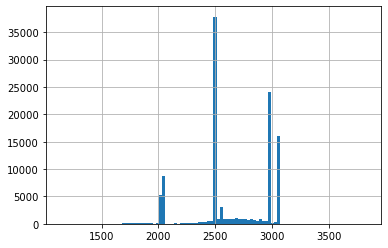

In [36]:
all_xray_df['OriginalImage[Width'].hist(bins=100)

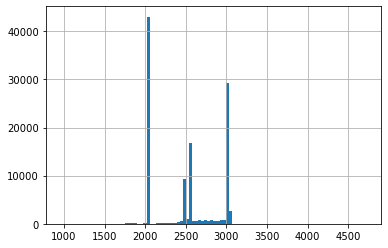

In [37]:
all_xray_df['Height]'].hist(bins=100)

In [38]:
width2500 = all_xray_df[(all_xray_df['OriginalImage[Width'] == 2500)]
width2500

Image Index                     Finding Labels  Follow-up #  \
2       00000001_002.png              Cardiomegaly|Effusion            2   
3       00000002_000.png                         No Finding            0   
5       00000003_001.png                             Hernia            1   
8       00000003_004.png                             Hernia            4   
12      00000004_000.png                        Mass|Nodule            0   
...                  ...                                ...          ...   
104746  00028066_002.png  Atelectasis|Effusion|Infiltration            2   
107219  00028928_000.png                         No Finding            0   
107276  00028948_005.png                             Hernia            5   
112111  00030798_000.png                         No Finding            0   
112114  00030801_000.png                         No Finding            0   

        Patient ID  Patient Age Patient Gender View Position  \
2                1           58              M            PA   
3                2           81              M            PA   
5                3           74              F            PA   
8                3           77              F            PA   
12               4           82              M            AP   
...            ...          ...            ...           ...   
104746       28066           24              M            PA   
107219       28928           73              F            PA   
107276       28948           87              F            PA   
112111       30798           30              M            PA   
112114       30801           39              M            PA   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
2                      2500     2048                        0.168  0.168   
3                      2500     2048                        0.171  0.171   
5                      2500     2048                        0.168  0.168   
8                      2500     2048                        0.168  0.168   
12                     2500     2048                        0.168  0.168   
...                     ...      ...                          ...    ...   
104746                 2500     2746                        0.143  0.143   
107219                 2500     3016                        0.139  0.139   
107276                 2500     3056                        0.139  0.139   
112111                 2500     2048                        0.171  0.171   
112114                 2500     2048                        0.168  0.168   

        Unnamed: 11  
2               NaN  
3               NaN  
5               NaN  
8               NaN  
12              NaN  
...             ...  
104746          NaN  
107219          NaN  
107276          NaN  
112111          NaN  
112114          NaN  

[37191 rows x 12 columns]

In [39]:
print(f'Images with width 2500: {len(width2500)} ({100.0*len(width2500)/len(all_xray_df) :.2f}%)')

Images with width 2500: 37191 (33.17%)


In [40]:
height2048 = all_xray_df[(all_xray_df['Height]'] == 2048)]
height2048

Image Index         Finding Labels  Follow-up #  Patient ID  \
2       00000001_002.png  Cardiomegaly|Effusion            2           1   
3       00000002_000.png             No Finding            0           2   
5       00000003_001.png                 Hernia            1           3   
8       00000003_004.png                 Hernia            4           3   
12      00000004_000.png            Mass|Nodule            0           4   
...                  ...                    ...          ...         ...   
95095   00024812_000.png             No Finding            0       24812   
95106   00024823_000.png             No Finding            0       24823   
95349   00025060_000.png             No Finding            0       25060   
112111  00030798_000.png             No Finding            0       30798   
112114  00030801_000.png             No Finding            0       30801   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
2                58              M            PA                 2500   
3                81              M            PA                 2500   
5                74              F            PA                 2500   
8                77              F            PA                 2500   
12               82              M            AP                 2500   
...             ...            ...           ...                  ...   
95095            39              M            PA                 2500   
95106            27              M            PA                 2500   
95349            35              M            PA                 2500   
112111           30              M            PA                 2500   
112114           39              M            PA                 2500   

        Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11  
2          2048                        0.168  0.168          NaN  
3          2048                        0.171  0.171          NaN  
5          2048                        0.168  0.168          NaN  
8          2048                        0.168  0.168          NaN  
12         2048                        0.168  0.168          NaN  
...         ...                          ...    ...          ...  
95095      2048                        0.168  0.168          NaN  
95106      2048                        0.168  0.168          NaN  
95349      2048                        0.168  0.168          NaN  
112111     2048                        0.171  0.171          NaN  
112114     2048                        0.168  0.168          NaN  

[37155 rows x 12 columns]

In [41]:
print(f'Images with height 2048: {len(height2048)} ({100.0*len(height2048)/len(all_xray_df) :.2f}%)')

Images with height 2048: 37155 (33.14%)


In [42]:
size2500x2048 = all_xray_df[(all_xray_df['OriginalImage[Width'] == 2500) & (all_xray_df['Height]'] == 2048)]
print(f'Images 2500x2048: {len(size2500x2048)} ({100.0*len(size2500x2048)/len(all_xray_df) :.2f}%)')

Images 2500x2048: 37153 (33.14%)


Almost 1/3 of the images has size 2500x2048

## Pneumonia cases

#### Map findings per single finding 

In [43]:
len(findings)

15

In [44]:
findings

{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

In [45]:
for finding in findings:
    all_xray_df[finding] = all_xray_df['Finding Labels'].map(lambda x: 1.0 if finding in x else 0)

all_xray_df

Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0                58              M            PA                 2682   
1                58              M            PA                 2894   
2                58              M            PA                 2500   
3                81              M            PA                 2500   
4                81              F            PA                 2582   
...             ...            ...           ...                  ...   
112115           39              M            PA                 2048   
112116           29              M            PA                 2048   
112117           42              F            PA                 2048   
112118           30              F            PA                 2048   
112119           27              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x  ...  Effusion  Pneumonia  \
0          2749                        0.143  ...       0.0        0.0   
1          2729                        0.143  ...       0.0        0.0   
2          2048                        0.168  ...       1.0        0.0   
3          2048                        0.171  ...       0.0        0.0   
4          2991                        0.143  ...       0.0        0.0   
...         ...                          ...  ...       ...        ...   
112115     2500                        0.168  ...       0.0        1.0   
112116     2500                        0.168  ...       0.0        0.0   
112117     2500                        0.168  ...       0.0        0.0   
112118     2500                        0.168  ...       0.0        0.0   
112119     2500                        0.171  ...       0.0        0.0   

        Pleural_Thickening  Fibrosis  Atelectasis  Infiltration  Edema  \
0                      0.0       0.0          0.0           0.0    0.0   
1                      0.0       0.0          0.0           0.0    0.0   
2                      0.0       0.0          0.0           0.0    0.0   
3                      0.0       0.0          0.0           0.0    0.0   
4                      0.0       0.0          0.0           0.0    0.0   
...                    ...       ...          ...           ...    ...   
112115                 0.0       0.0          0.0           0.0    0.0   
112116                 0.0       0.0          0.0           0.0    0.0   
112117                 0.0       0.0          0.0           0.0    0.0   
112118                 0.0       0.0          0.0           0.0    0.0   
112119                 0.0       0.0          0.0           0.0    0.0   

        Consolidation  No Finding  Nodule  
0                 0.0         0.0     0.0  
1                 0.0         0.0     0.0  
2                 0.0         0.0     0.0  
3                 0.0         1.0     0.0  
4                 0.0         0.0     0.0  
...               ...         ...     ...  
112115            0.0         0.0     0.0  
112116            0.0         1.0     0.0  
112117            0.0         1.0    

In [46]:
pneumonia = all_xray_df[all_xray_df['Pneumonia'] == 1]
pneumonia

Image Index                                     Finding Labels  \
48      00000013_010.png                    Effusion|Pneumonia|Pneumothorax   
126     00000032_012.png          Atelectasis|Consolidation|Edema|Pneumonia   
253     00000056_000.png                                   Nodule|Pneumonia   
276     00000061_012.png  Edema|Effusion|Infiltration|Pleural_Thickening...   
279     00000061_015.png                                          Pneumonia   
...                  ...                                                ...   
111557  00030536_007.png                Atelectasis|Consolidation|Pneumonia   
111627  00030570_001.png                       Edema|Infiltration|Pneumonia   
111767  00030621_002.png                                          Pneumonia   
111845  00030637_016.png                            Consolidation|Pneumonia   
112115  00030801_001.png                                     Mass|Pneumonia   

        Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
48               10          13           60              M            AP   
126              12          32           55              F            AP   
253               0          56           76              M            PA   
276              12          61           77              M            AP   
279              15          61           77              M            AP   
...             ...         ...          ...            ...           ...   
111557            7       30536           56              F            AP   
111627            1       30570           29              F            AP   
111767            2       30621           22              F            AP   
111845           16       30637           48              M            AP   
112115            1       30801           39              M            PA   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
48                     3056     2544                        0.139  ...   
126                    2500     2048                        0.168  ...   
253                    2500     2048                        0.168  ...   
276                    3056     2544                        0.139  ...   
279                    3056     2544                        0.139  ...   
...                     ...      ...                          ...  ...   
111557                 3056     2544                        0.139  ...   
111627                 3056     2544                        0.139  ...   
111767                 3056     2544                        0.139  ...   
111845                 3056     2544                        0.139  ...   
112115                 2048     2500                        0.168  ...   

        Effusion  Pneumonia  Pleural_Thickening  Fibrosis  Atelectasis  \
48           1.0        1.0                 0.0       0.0          0.0   
126          0.0        1.0                 0.0       0.0          1.0   
253          0.0        1.0                 0.0       0.0          0.0   
276          1.0        1.0                 1.0       0.0          0.0   
279          0.0        1.0                 0.0       0.0          0.0   
...          ...        ...                 ...       ...          ...   
111557       0.0        1.0                 0.0       0.0          1.0   
111627       0.0        1.0                 0.0       0.0          0.0   
111767       0.0        1.0                 0.0       0.0          0.0   
111845       0.0        1.0                 0.0       0.0          0.0   
112115       0.0        1.0                 0.0       0.0          0.0   

        Infiltration  Edema  Consolidation  No Finding  Nodule  
48               0.0    0.0            0.0         0.0     0.0  
126              0.0    1.0            1.0         0.0     0.0  
253              0.0    0.0            0.0         0.0     1.0  
276              1.0    1.0            0.0         0.0     0.0  
279              0.0    0.0         

In [47]:
all_findings = all_xray_df[all_xray_df["No Finding"] == 0]
print(f'All findings: {len(all_findings)}')

All findings: 51759


In [48]:
print(f'Pneumonia images: {len(pneumonia)} ({100.0*len(pneumonia)/len(all_xray_df) :.2f}% of all)')
print(f'Pneumonia images: {len(pneumonia)} ({100.0*len(pneumonia)/len(all_findings) :.2f}% of findings)')

Pneumonia images: 1431 (1.28% of all)
Pneumonia images: 1431 (2.76% of findings)


In [49]:
no_pneumonia = all_xray_df[all_xray_df["Pneumonia"] == 0]
print(f'No pneumonia: {len(no_pneumonia)}')

No pneumonia: 110689


In [50]:
no_pneumonia_findings = all_xray_df[ (all_xray_df["Pneumonia"] == 0) & (all_xray_df["No Finding"] == 0) ]
print(f'No pneumonia among findings: {len(no_pneumonia_findings)}')

No pneumonia among findings: 50328


### Feature distributions among pneumonia records

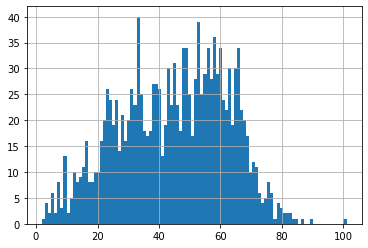

In [51]:
pneumonia['Patient Age'].hist(bins=100)

In [52]:
pneumonia[pneumonia['Patient Age'] <= 100][['Patient Age']].describe()

Patient Age
count  1430.000000
mean     44.670629
std      17.639098
min       2.000000
25%      31.000000
50%      46.000000
75%      59.000000
max      90.000000

##### Age range for pneumonia cases: from 2 to 90 years old

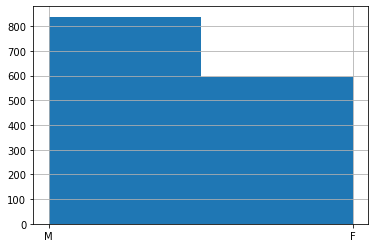

In [53]:
pneumonia['Patient Gender'].hist(bins=2)

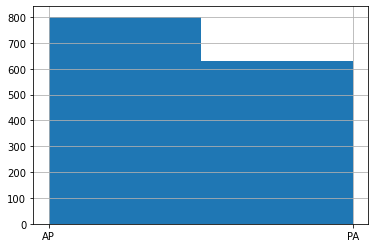

In [54]:
pneumonia['View Position'].hist(bins=2)

In [55]:
pneumonia_unique_patients_num = pneumonia['Patient ID'].nunique()
print(f'Total pneumonia patients: {pneumonia_unique_patients_num}, average number records per patient: {len(pneumonia)/pneumonia_unique_patients_num :.2f}')

Total pneumonia patients: 1008, average number records per patient: 1.42


In [56]:
pneumonia_records_per_patient = []
for pid in pneumonia['Patient ID'].unique():
    pneumonia_records_per_patient.append(len(pneumonia[pneumonia['Patient ID'] == pid]))

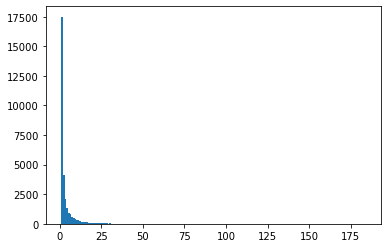

In [57]:
plt.hist(records_per_patient, bins=max(records_per_patient))
plt.show()

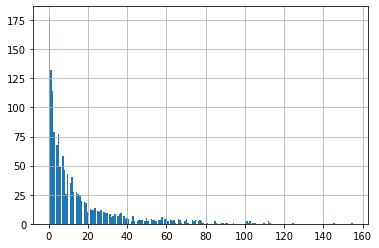

In [58]:
pneumonia['Follow-up #'].hist(bins=200)

Features mostly retained the same distribution among the pneumonia records as in the original dataset. (For 'View Position', 'AP' is slightly more prevalent than 'PA' in the pneumonia records, whereas it is vice versa in the original dataset. But the prevalence is not very significant in both cases).

### Pneumonia & comorbid findings

[Text(0, 0.5, 'Number of Images with Label')]

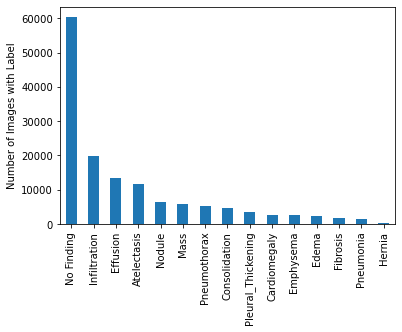

In [59]:
ax = all_xray_df[findings].sum().sort_values(ascending=False).plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')


In [60]:
(all_xray_df[findings].sum()/len(all_xray_df)).sort_values(ascending=False)

No Finding            0.538361
Infiltration          0.177435
Effusion              0.118775
Atelectasis           0.103095
Nodule                0.056466
Mass                  0.051570
Pneumothorax          0.047289
Consolidation         0.041625
Pleural_Thickening    0.030191
Cardiomegaly          0.024759
Emphysema             0.022440
Edema                 0.020540
Fibrosis              0.015037
Pneumonia             0.012763
Hernia                0.002025
dtype: float64

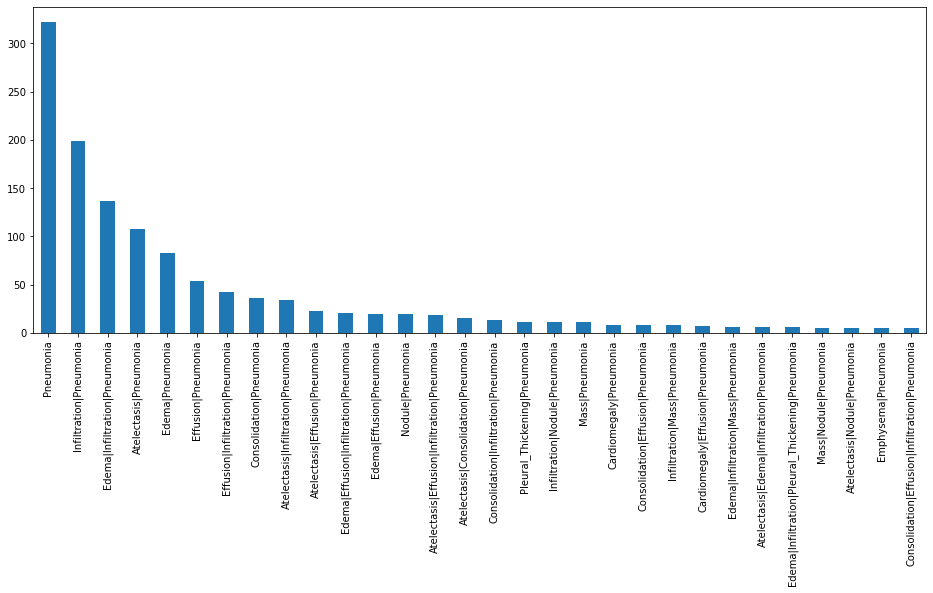

In [61]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df['Pneumonia']==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')


In [62]:
all_xray_df[all_xray_df['Pneumonia']==1]['Finding Labels'].value_counts()[0:30]

Pneumonia                                          322
Infiltration|Pneumonia                             199
Edema|Infiltration|Pneumonia                       137
Atelectasis|Pneumonia                              108
Edema|Pneumonia                                     83
Effusion|Pneumonia                                  54
Effusion|Infiltration|Pneumonia                     42
Consolidation|Pneumonia                             36
Atelectasis|Infiltration|Pneumonia                  34
Atelectasis|Effusion|Pneumonia                      23
Edema|Effusion|Infiltration|Pneumonia               21
Edema|Effusion|Pneumonia                            19
Nodule|Pneumonia                                    19
Atelectasis|Effusion|Infiltration|Pneumonia         18
Atelectasis|Consolidation|Pneumonia                 15
Consolidation|Infiltration|Pneumonia                13
Pleural_Thickening|Pneumonia                        11
Infiltration|Nodule|Pneumonia                       11
Mass|Pneum

### Frequency of comorbid conditions with pneumonia (per each condition)

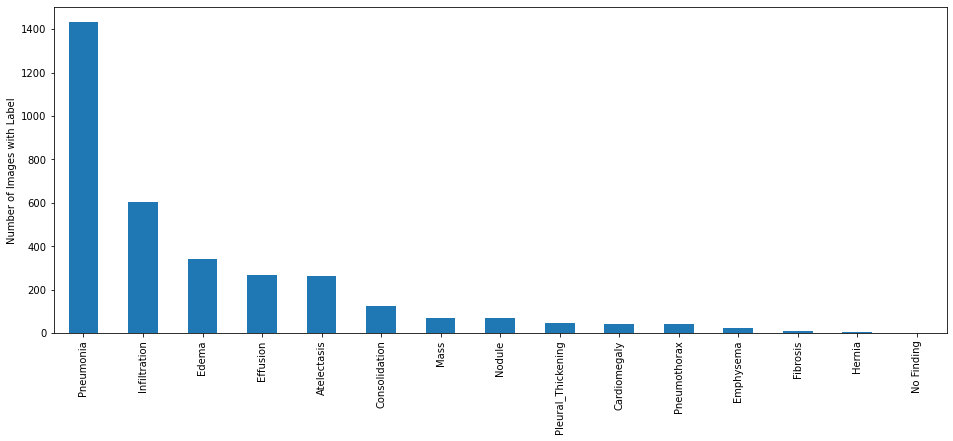

In [63]:
plt.figure(figsize=(16,6))
ax = pneumonia[findings].sum().sort_values(ascending=False).plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')
plt.show()

### Number of deseases per patient

#### Full dataset

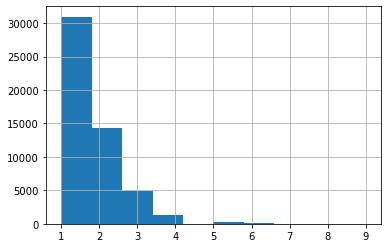

In [64]:
all_findings[findings].sum(axis=1).hist(bins=10)

#### Pneumonia

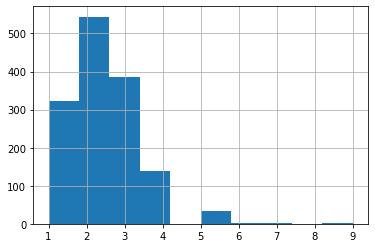

In [65]:
pneumonia[findings].sum(axis=1).hist(bins=10)

In the whole dataset, one finding is prevalent, whereas with pneumonia in most cases it is accompanied with one or two more findings.

# Pixel-wise analysis

In [66]:
sample_df.head(3)

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                3056                 2544                        0.139   
1                2500                 2048                        0.168   
2                2500                 2048                        0.168   

   OriginalImagePixelSpacing_y  
0                        0.139  
1                        0.168  
2                        0.168

In [67]:
for finding in findings:
    sample_df[finding] = sample_df['Finding Labels'].map(lambda x: 1.0 if finding in x else 0)

sample_df.head(5)

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  ...  \
0                3056                 2544                        0.139  ...   
1                2500                 2048                        0.168  ...   
2                2500                 2048                        0.168  ...   
3                2992                 2991                        0.143  ...   
4                2500                 2048                        0.168  ...   

   Effusion  Pneumonia  Pleural_Thickening  Fibrosis  Atelectasis  \
0       0.0        0.0                 1.0       0.0          0.0   
1       0.0        0.0                 0.0       0.0          0.0   
2       0.0        0.0                 0.0       0.0          0.0   
3       0.0        0.0                 0.0       0.0          1.0   
4       1.0        0.0                 0.0       0.0          0.0   

   Infiltration  Edema  Consolidation  No Finding  Nodule  
0           1.0    0.0            0.0         0.0     0.0  
1           0.0    0.0            0.0         0.0     0.0  
2           0.0    0.0            0.0         1.0     0.0  
3           0.0    0.0            0.0         0.0     0.0  
4           0.0    1.0            0.0         0.0     0.0  

[5 rows x 26 columns]

In [68]:
def get_image_path(row):
    fpath = None
    f = row['Image Index']
    for d in range(12):
        dname = 'images_' + str(d).zfill(3)
        fname = '/data/' + dname + '/images/' + f
        if os.path.isfile(fname):
            fpath = fname
            break
    return fpath

sample_df['image_path'] = sample_df.apply(get_image_path, axis=1)
sample_df.head(5)

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  ...  \
0                3056                 2544                        0.139  ...   
1                2500                 2048                        0.168  ...   
2                2500                 2048                        0.168  ...   
3                2992                 2991                        0.143  ...   
4                2500                 2048                        0.168  ...   

   Pneumonia  Pleural_Thickening  Fibrosis  Atelectasis  Infiltration  Edema  \
0        0.0                 1.0       0.0          0.0           1.0    0.0   
1        0.0                 0.0       0.0          0.0           0.0    0.0   
2        0.0                 0.0       0.0          0.0           0.0    0.0   
3        0.0                 0.0       0.0          1.0           0.0    0.0   
4        0.0                 0.0       0.0          0.0           0.0    1.0   

   Consolidation  No Finding  Nodule                                image_path  
0            0.0         0.0     0.0  /data/images_001/images/00000013_005.png  
1            0.0         0.0     0.0  /data/images_001/images/00000013_026.png  
2            0.0         1.0     0.0  /data/images_001/images/00000017_001.png  
3            0.0         0.0     0.0  /data/images_001/images/00000030_001.png  
4            0.0         0.0     0.0  /data/images_001/images/00000032_001.png  

[5 rows x 27 columns]

In [69]:
pneumo_samples = sample_df[sample_df['Pneumonia'] == 1]
len(pneumo_samples)

62

In [70]:
pneumonia_example_1 = pneumo_samples.iloc[0]
pneumonia_example_1

Image Index                                            00001373_010.png
Finding Labels                          Cardiomegaly|Effusion|Pneumonia
Follow-up #                                                          10
Patient ID                                                         1373
Patient Age                                                        058Y
Patient Gender                                                        M
View Position                                                        AP
OriginalImageWidth                                                 3056
OriginalImageHeight                                                2544
OriginalImagePixelSpacing_x                                       0.139
OriginalImagePixelSpacing_y                                       0.139
Mass                                                                  0
Pneumothorax                                                          0
Hernia                                                          

In [71]:
!ls /data/

ARXIV_V5_CHESTXRAY.pdf	images_002  images_007	images_012
BBox_List_2017.csv	images_003  images_008	LOG_CHESTXRAY.pdf
Data_Entry_2017.csv	images_004  images_009	README_CHESTXRAY.pdf
FAQ_CHESTXRAY.pdf	images_005  images_010	test_list.txt
images_001		images_006  images_011	train_val_list.txt


In [72]:
def show_image_distr(img_data):
    f = plt.figure()
    f.set_figwidth(10)

    s1 = f.add_subplot(1, 2, 1)
    s1.set_title('Image')
    plt.imshow(img_data, cmap='gray')


    s2 = f.add_subplot(1, 2, 2)
    s2.set_title('Intensity Distribution')
    plt.hist(img_data.ravel(), bins = 256)

    plt.show()

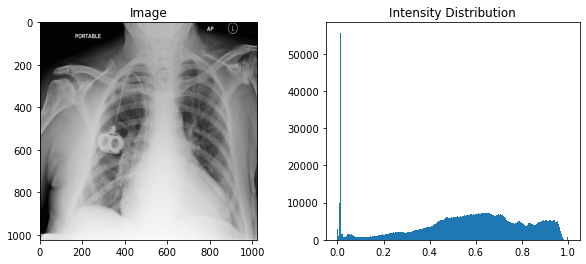

In [73]:
ex1_data = image.imread('/data/images_002/images/' + pneumonia_example_1['Image Index'])
show_image_distr(ex1_data)

In [74]:
def get_image_data(row):
    fpath = row['image_path']
    if fpath is not None:
        img = image.imread(fpath)
        return img
    else:
        return None

In [75]:
pneumo_samples['image_data'] = pneumo_samples.apply(get_image_data, axis=1)
pneumo_samples.head(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Image Index                        Finding Labels  Follow-up #  \
256  00001373_010.png       Cardiomegaly|Effusion|Pneumonia           10   
287  00001529_004.png  Consolidation|Infiltration|Pneumonia            4   

     Patient ID Patient Age Patient Gender View Position  OriginalImageWidth  \
256        1373        058Y              M            AP                3056   
287        1529        054Y              F            PA                2992   

     OriginalImageHeight  OriginalImagePixelSpacing_x  ...  \
256                 2544                        0.139  ...   
287                 2991                        0.143  ...   

     Pleural_Thickening  Fibrosis  Atelectasis  Infiltration  Edema  \
256                 0.0       0.0          0.0           0.0    0.0   
287                 0.0       0.0          0.0           1.0    0.0   

     Consolidation  No Finding  Nodule  \
256            0.0         0.0     0.0   
287            1.0         0.0     0.0   

                                   image_path  \
256  /data/images_002/images/00001373_010.png   
287  /data/images_002/images/00001529_004.png   

                                            image_data  
256  [[0.0, 0.003921569, 0.007843138, 0.007843138, ...  
287  [[0.91764706, 0.89411765, 0.8509804, 0.7960784...  

[2 rows x 28 columns]

In [76]:
pneumo_data = pneumo_samples[pneumo_samples['image_data'].notna()]['image_data'].values
pneumo_data.shape

(60,)

In [77]:
pneumo_intensities = []
for data in pneumo_data:
    pneumo_intensities.extend(data.flatten().tolist())

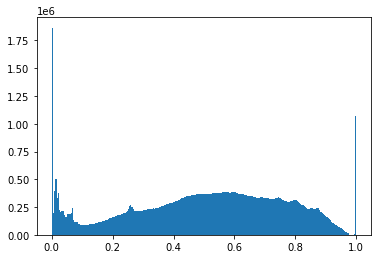

In [78]:
plt.hist(pneumo_intensities,bins=256)
plt.show()

#### Sample Pneumonia distribution with background

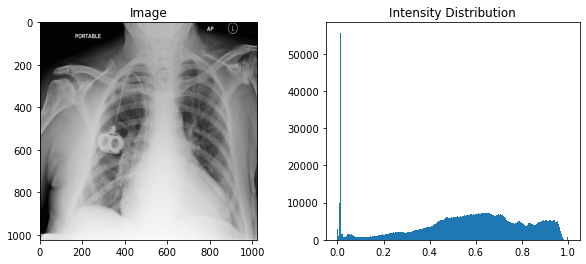

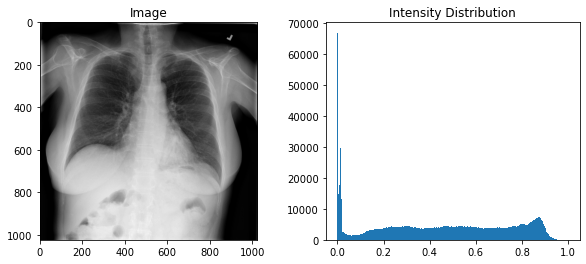

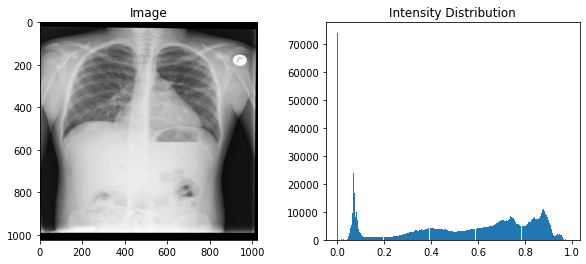

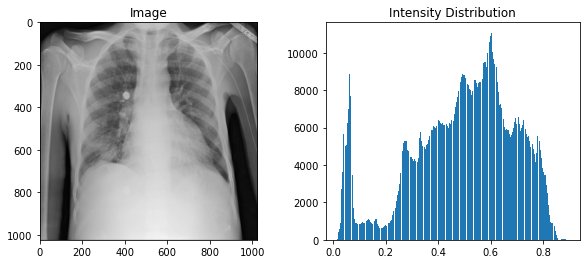

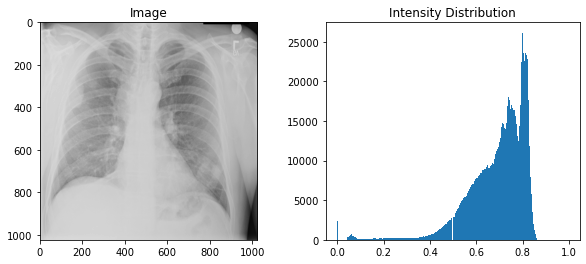

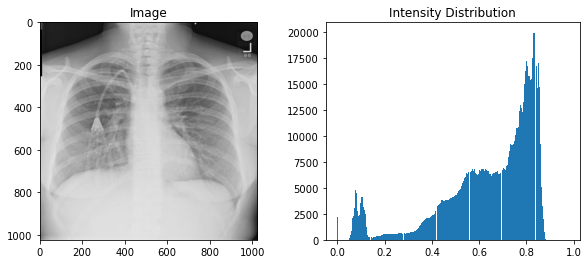

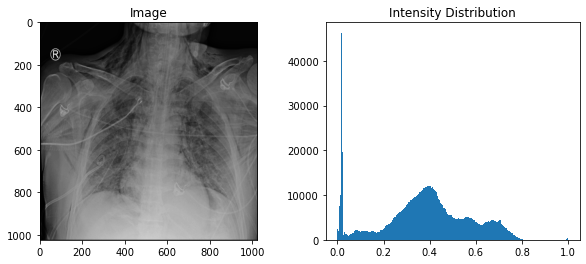

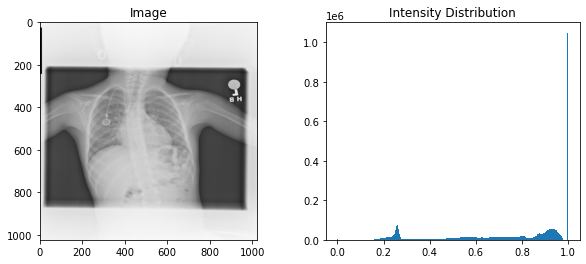

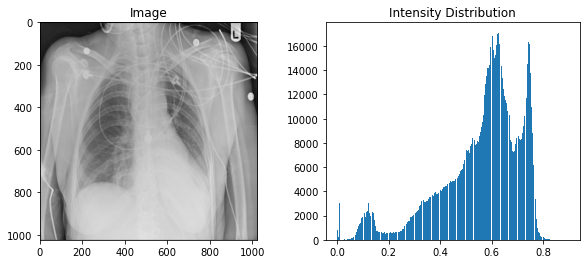

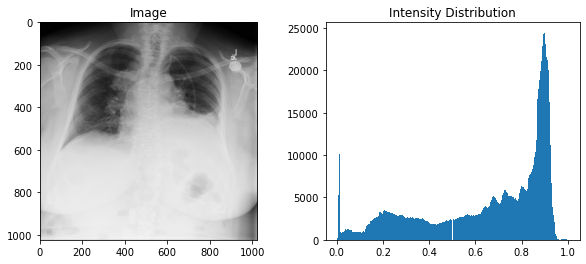

In [79]:
for data in pneumo_data[:10]:
    show_image_distr(data)

### Remove background

In [80]:
def show_image_mask(img_data, th):
    f = plt.figure()
    f.set_figwidth(15)

    s1 = f.add_subplot(1, 3, 1)
    s1.set_title('Image')
    plt.imshow(img_data, cmap='gray')

    mask = data > th

    s2 = f.add_subplot(1, 3, 2)
    s2.set_title('Mask')
    plt.imshow(mask.astype(int)*255, cmap='gray')
    
    s3 = f.add_subplot(1, 3, 3)
    s3.set_title('Intensity Distribution')
    plt.hist(img_data[mask], bins = 256)

    plt.show()

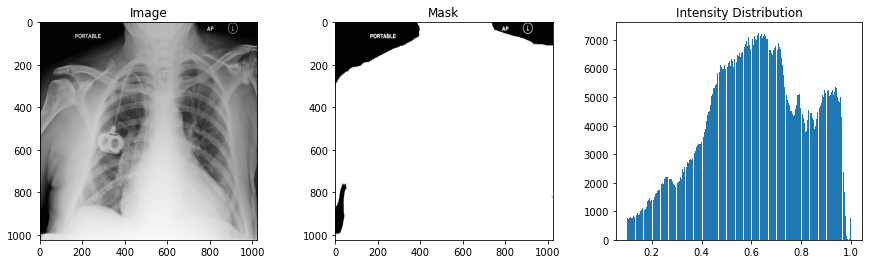

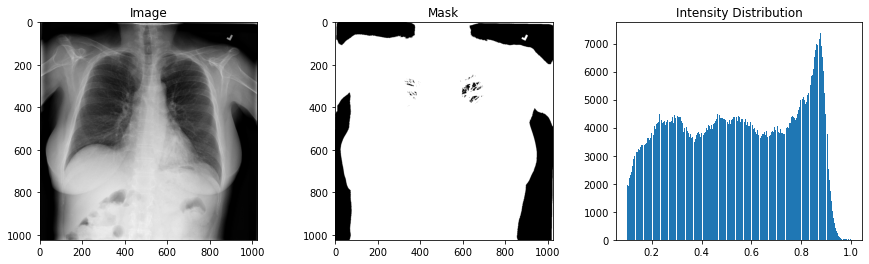

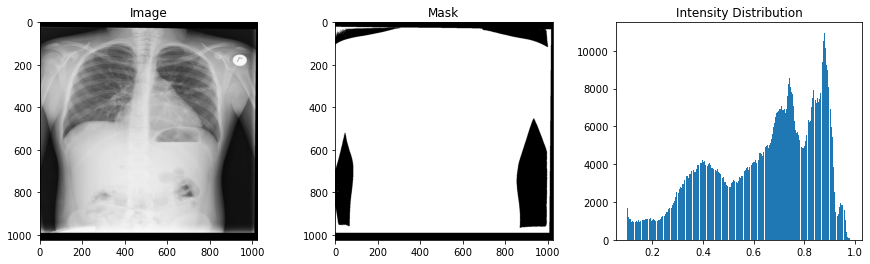

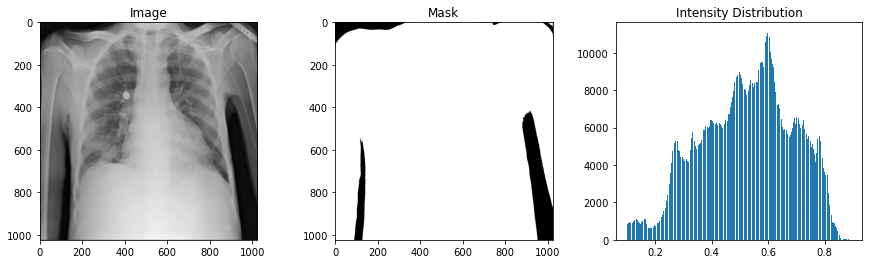

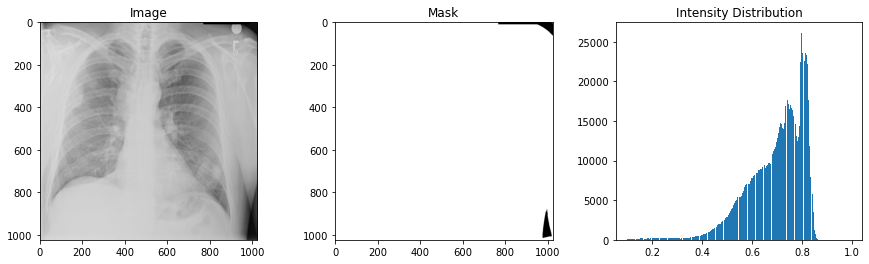

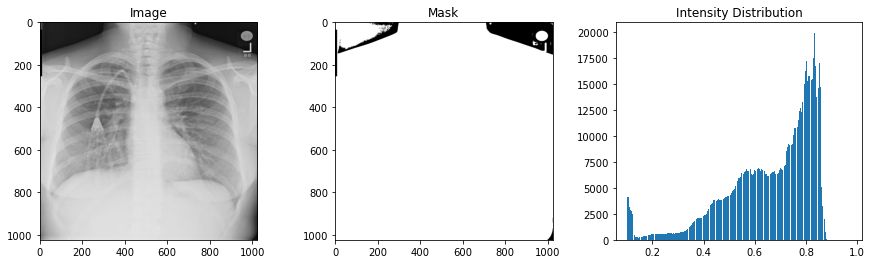

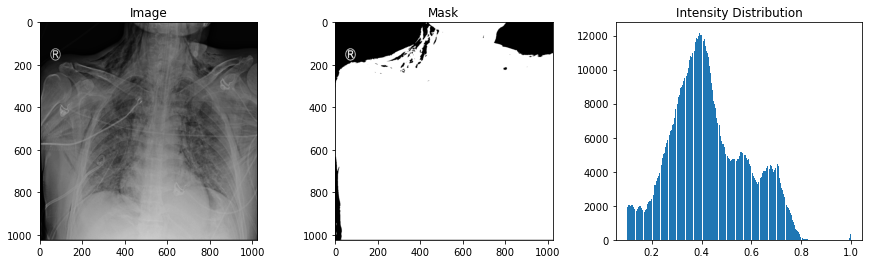

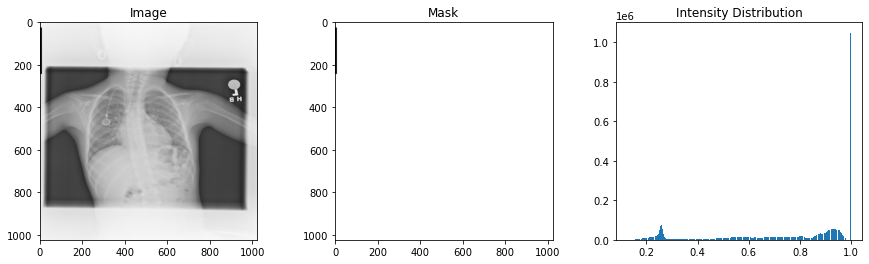

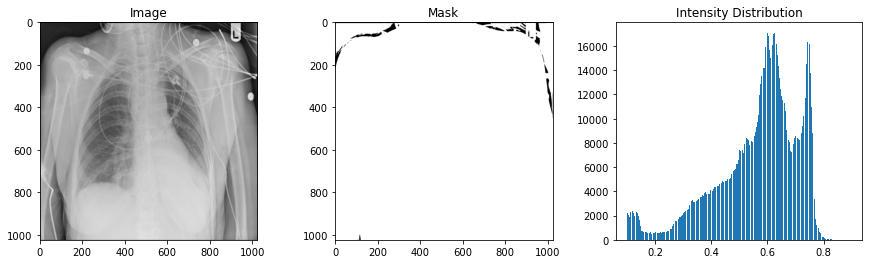

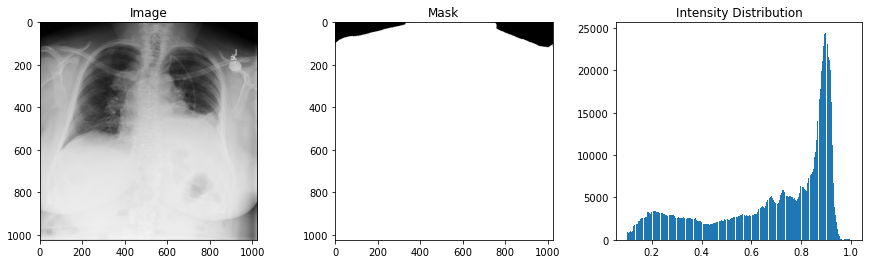

In [81]:
background_threshold = 0.1

for data in pneumo_data[:10]:
    show_image_mask(data, background_threshold)

#### Need to remove foreground too (excessively white areas of extenal entities)

In [82]:
foreground_threshold = 0.9

Label: Pneumonia, number of samples for intensity: 62


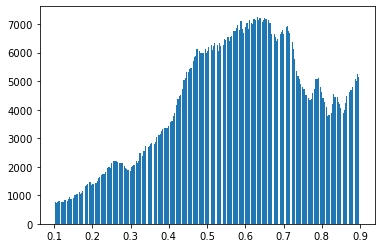

In [83]:
max_samples = 1000
def get_intensities(label):
    intensities = []
    paths = sample_df[sample_df[label]==1].head(max_samples)['image_path'].values
    print(f'Label: {label}, number of samples for intensity: {len(paths)}')
    for path in paths:
        data = image.imread(path)
        mask = (data > background_threshold) & (data < foreground_threshold)
        intensities.extend(data[mask].flatten().tolist())
        return intensities
    
plt.hist(get_intensities('Pneumonia'), bins = 256)
plt.show()

### Compare Intensity of Images with Pneumonia with No Findings or Other Conditions 

In [84]:
max_samples = 1000

def get_intensities(label):
    intensities = []
    paths = sample_df[sample_df[label]==1].head(max_samples)['image_path'].values
    print(f'Label: {label}, number of samples for intensity: {len(paths)}')
    for path in paths:
        data = image.imread(path)
        mask = (data > background_threshold) & (data < foreground_threshold)
        intensities.extend(data[mask].flatten().tolist())
        return intensities

Label: Mass, number of samples for intensity: 284
Label: Pneumothorax, number of samples for intensity: 271
Label: Hernia, number of samples for intensity: 13
Label: Cardiomegaly, number of samples for intensity: 141
Label: Emphysema, number of samples for intensity: 127
Label: Effusion, number of samples for intensity: 644
Label: Pneumonia, number of samples for intensity: 62
Label: Pleural_Thickening, number of samples for intensity: 176
Label: Fibrosis, number of samples for intensity: 84
Label: Atelectasis, number of samples for intensity: 508
Label: Infiltration, number of samples for intensity: 967
Label: Edema, number of samples for intensity: 118
Label: Consolidation, number of samples for intensity: 226
Label: No Finding, number of samples for intensity: 1000
Label: Nodule, number of samples for intensity: 313


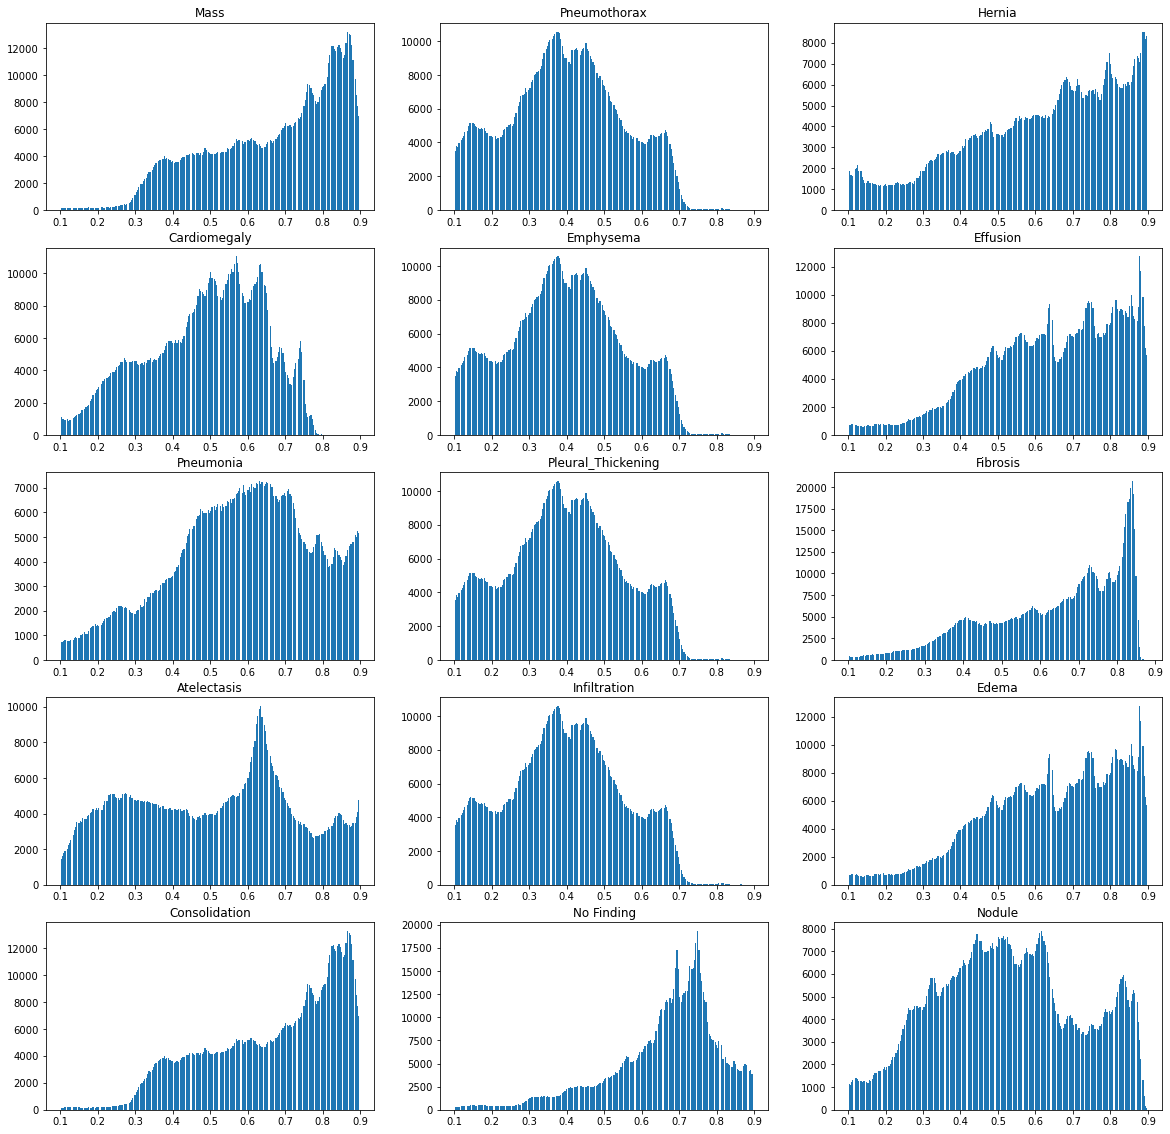

In [85]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

for i,finding in enumerate(findings):
    intensities = get_intensities(finding)

    s = f.add_subplot(5, len(findings)/5, i+1)
    s.set_title(finding)
    plt.hist(intensities, bins = 256)
    
plt.show()

#### Similar Distribution Group 1:  Emphysema, Pleural Thickening, Pneumothorax, Infitration

Label: Emphysema, number of samples for intensity: 127
Label: Pleural_Thickening, number of samples for intensity: 176
Label: Pneumothorax, number of samples for intensity: 271
Label: Infiltration, number of samples for intensity: 967


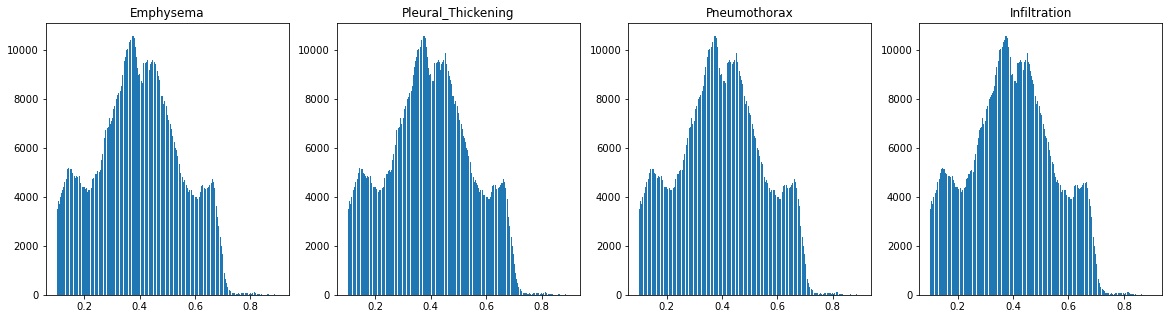

In [86]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

for i,finding in enumerate([ 'Emphysema', 'Pleural_Thickening', 'Pneumothorax', 'Infiltration']):
    intensities = get_intensities(finding)

    s = f.add_subplot(1, 4, i+1)
    s.set_title(finding)
    plt.hist(intensities, bins = 256)
    
plt.show()

#### Similar Distribution Group 2: Consolidation, Edema, Effusion, Hernia

Label: Consolidation, number of samples for intensity: 226
Label: Edema, number of samples for intensity: 118
Label: Effusion, number of samples for intensity: 644
Label: Hernia, number of samples for intensity: 13


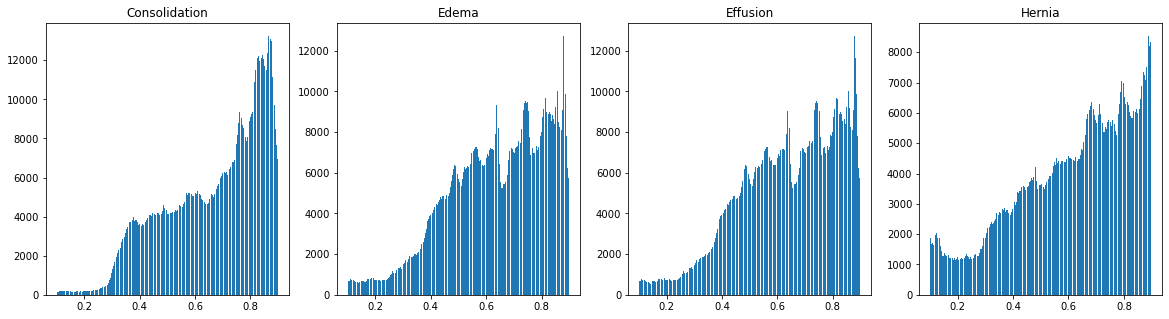

In [87]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

for i,finding in enumerate([ 'Consolidation', 'Edema', 'Effusion', 'Hernia']):
    intensities = get_intensities(finding)

    s = f.add_subplot(1, 4, i+1)
    s.set_title(finding)
    plt.hist(intensities, bins = 256)
    
plt.show()

#### Similar Distribution Group 3: 'Pneumonia', 'Nodule', 'Cardiomegaly'

Label: Pneumonia, number of samples for intensity: 62
Label: Nodule, number of samples for intensity: 313
Label: Cardiomegaly, number of samples for intensity: 141


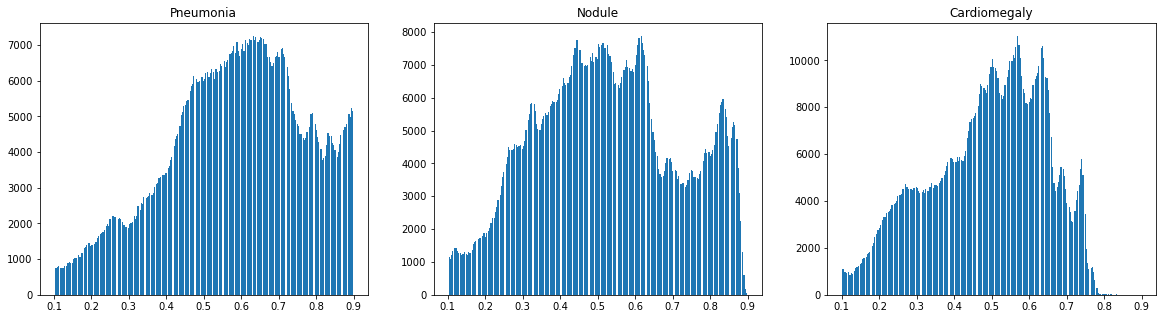

In [89]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

for i,finding in enumerate([ 'Pneumonia', 'Nodule', 'Cardiomegaly']):
    intensities = get_intensities(finding)

    s = f.add_subplot(1, 3, i+1)
    s.set_title(finding)
    plt.hist(intensities, bins = 256)
    
plt.show()

#### Summary

* Images in the dataset need to be normalized, in the range from 0.0 to 1.0
* Background (almost black) needs to be removed, suggested threshold: > 0.1
* Foreground (almost white) needs to be removed too, suggested thereshold: < 0.9. (These could be external entities, absorbing light very well, possibly pieces of plastic?)
* 'Pneumonia' images intensity distribution is quite similar to those of 'Nodule', and somewhat similar to those of 'Cardiomegaly'.
* 'Consolidation', 'Edema', 'Effusion', 'Hernia' have quite different from Pneumonia, but very similar to one another distributions.
* Also, 'Emphysema', 'Pleural Thickening', 'Pneumothorax', 'Infitration' form another group that has distribution very similar to one another